In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer
from datetime import timedelta, date
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols
from scipy import stats
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from tqdm import tqdm
import itertools
from dtw import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import time
from sklearn.metrics import silhouette_score


import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras import regularizers
#%matplotlib inline

Using TensorFlow backend.


In [2]:
store_data=pd.read_csv('/Users/s0c02nj/Desktop/Store_Cluster/store.csv')
train=pd.read_csv('/Users/s0c02nj/Desktop/Store_Cluster/train.csv')

FileNotFoundError: [Errno 2] File b'/Users/s0c02nj/Desktop/Store_Cluster/store.csv' does not exist: b'/Users/s0c02nj/Desktop/Store_Cluster/store.csv'

In [ ]:
train.head()

#### Time Series Analysis on Store Data ------> Temporal Part of the Data

In [ ]:
unique_stores = list(train['Store'].unique())

In [6]:
#Store1_data_analysis
df_s1 = train[train['Store'] == 14]

In [7]:
unique_stores = list(train['Store'].unique())
time_av = []
for store in unique_stores:
    time_av.append(train[train['Store'] == store].shape[0])

In [8]:
np.unique(time_av)

array([758, 941, 942])

In [9]:
#Converting to Date_Time_Format
col = 'date'
df_s1['Date_new'] = pd.to_datetime(df_s1['Date'])

/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#Extracting the Date,month and Year
df_s1['Week'] = df_s1['Date_new'].dt.week
df_s1['Month'] = df_s1['Date_new'].dt.month
df_s1['Day'] = df_s1['Date_new'].dt.day
df_s1['Year'] = df_s1['Date_new'].dt.year

/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [11]:
df_s1['Time'] = range(0,len(df_s1))[::-1]
df_s1.index = range(0,len(df_s1))
df_s1 = df_s1.drop(['Date_new'],axis = 1)

/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Time Series Plot of Sales')

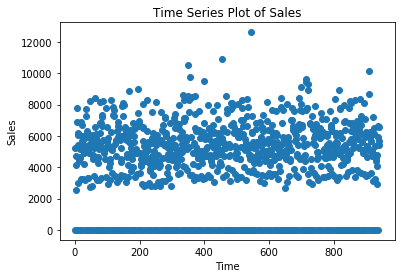

In [940]:
#Plotting the Time Series
plt.scatter(df_s1['Time'],df_s1['Sales'])
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Time Series Plot of Sales')
#plt.ylim(0,10)


Text(0.5, 1.0, 'Time Series Plot of Sales')

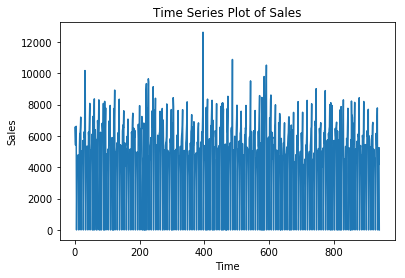

In [942]:
plt.plot(df_s1['Sales'])
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Time Series Plot of Sales')

+ 1.There are zero values of Sales for several time points, which needs to be removed.
+ 2.Need to check if the data is stationary or not
+ 3.We can go for statistical comparisons.

In [14]:
#Time Series Testing
timeseries = df_s1['Sales']
adfTest = adfuller(timeseries, autolag='AIC')

In [15]:
adfTest[1]

1.4726745167750548e-07

+ Though we can observe clear pattern indicating that at Day of Week -->'7', the value is 0.
+ So,we need to understand the reasons and factors and separate out the same
+ So,there will be autocorrelation between the output errors --> Observations won't be indepedent.

In [16]:
durbin_watson(timeseries)

0.435377153779586

+ Durbin Watson Test of Serial Correlation indicates that their is serial correlation present in the observations 
+ and hence we will be doing dummy variable regression with the independent variables to remove any significant effect

In [17]:
df_s1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,Month,Day,Year,Time
0,14,5,2015-07-31,6544,710,1,1,0,1,31,7,31,2015,941
1,14,4,2015-07-30,5672,613,1,1,0,1,31,7,30,2015,940
2,14,3,2015-07-29,5412,579,1,1,0,1,31,7,29,2015,939
3,14,2,2015-07-28,5957,628,1,1,0,1,31,7,28,2015,938
4,14,1,2015-07-27,6614,727,1,1,0,1,31,7,27,2015,937


In [18]:
np.corrcoef(df_s1['Sales'],df_s1['Customers'])

array([[1.        , 0.98289125],
       [0.98289125, 1.        ]])

+ The above result signifies that the Sales and Customers have the same information and hence we can use anyone for the embeddings
+ Hence going for Dummy Variable Regression Model to remove Serial Correlation Effect

#### Dummy Variable Regression Model

In [19]:
#Converting the columns to categorical variables
#cols = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday','Week','Month','Day','Year']

dummy_model = ols(formula='Sales~C(DayOfWeek)+C(Open)+C(StateHoliday)+'
                      'C(SchoolHoliday)+C(Week)+C(Month)+C(Day)+C(Day)', 
                      data=df_s1).fit()

In [20]:
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     92.96
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:50:09   Log-Likelihood:                -7512.5
No. Observations:                 942   AIC:                         1.523e+04
Df Residuals:                     838   BIC:                         1.574e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1456.7740    234.178      6.221      0.000     997.129    1916.419
C(DayOfWeek)[T.2]      -855.9901     91.869     -9.317      0.000   -1036.311    -675.669
C(DayOfWeek)[T.3]     -1272.7971     92.297    -13.790      0.000   -1453.958   -1091.636
C(DayOfWeek)[T.4]     -1192.7112     93.170    -12.801      0.000   -1375.585   -1009.837
C(DayOfWeek)[T.5]      -977.7602     92.664    -10.552      0.000   -1159.640    -795.880
C(DayOfWeek)[T.6]     -3316.2528     95.944    -34.564      0.000   -3504.572   -3127.934
C(DayOfWeek)[T.7]     -1495.0266    142.945    -10.459      0.000   -1775.598   -1214.455
C(Open)[T.1]           5366.9085    130.033     41.273      0.000    5111.680    5622.137
C(StateHoliday)[T.0]   -132.3784     84.259     -1.571      0.117    -297.762      33.005
C(StateHoliday)[T.a]   -766.6837    186.550     -4.110      0.000   -1132.844    -400.524
C(StateHoliday)[T.b]  -1083.4032    293.291     -3.694      0.000   -1659.075    -507.731
C(StateHoliday)[T.c]   -565.0211    395.454     -1.429      0.153   -1341.217     211.175
C(SchoolHoliday)[T.1]  -131.8235     94.337     -1.397      0.163    -316.987      53.340
C(Week)[T.2]           1380.3414    280.006      4.930      0.000     830.747    1929.936
C(Week)[T.3]            -51.7408    300.073     -0.172      0.863    -640.724     537.243
C(Week)[T.4]            611.9820    298.556      2.050      0.041      25.976    1197.988
C(Week)[T.5]           -649.3180    298.425     -2.176      0.030   -1235.067     -63.569
C(Week)[T.6]            415.8366    450.649      0.923      0.356    -468.696    1300.369
C(Week)[T.7]           -878.2360    470.389     -1.867      0.062   -1801.515      45.044
C(Week)[T.8]             37.5955    477.469      0.079      0.937    -899.580     974.771
C(Week)[T.9]          -1291.9717    479.071     -2.697      0.007   -2232.291    -351.653
C(Week)[T.10]          -365.7219    586.290     -0.624      0.533   -1516.492     785.048
C(Week)[T.11]         -1479.6993    608.650     -2.431      0.015   -2674.357    -285.041
C(Week)[T.12]          -321.7301    620.785     -0.518      0.604   -1540.206     896.746
C(Week)[T.13]         -1129.4920    613.415     -1.841      0.066   -2333.503      74.519
C(Week)[T.14]           671.8215    661.556      1.016      0.310    -626.680    1970.323
C(Week)[T.15]           895.8991    711.841      1.259      0.209    -501.301    2293.099
C(Week)[T.16]           809.7698    726.490      1.115      0.265    -616.183    2235.723
C(Week)[T.17]           464.0241    732.788      0.633      0.527    -974.291    1902.340
C(Week)[T.18]          1194.5673    726.868      1.643      0.101    -232.129    2621.263
C(Week)[T.19]          1434.3242    772.548      1.857      0.064     -82.033    2950.681
C(Week)[T.20]          

+ The model gives good accuracy and adequacy which indicates for the need for the model
+ Checking the serial correlation of the errors after removing the causal effects

In [21]:
#DW Test on residuals
resid = dummy_model.resid
durbin_watson(resid)

1.4227290582091774

+ Which Indicates that we were able to separate out the factors at max to get serial correlation free data which gives
+ the inherenet characteristics of the sale

+ Now we will go for checking the similarity between the two series. First checking the distribution

In [22]:
#Normality Test
k, p = stats.normaltest(resid)

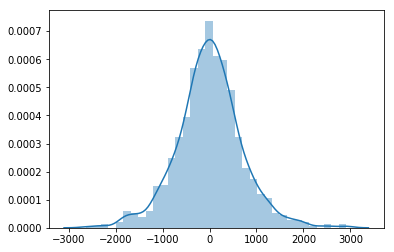

In [23]:
sns.distplot(resid)

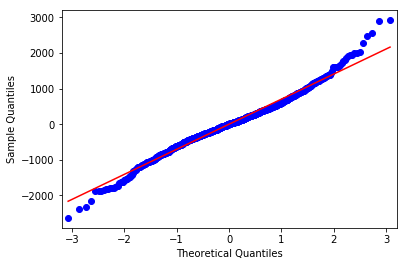

In [24]:
qqplot(resid, line='s')
plt.show()

In [25]:
stat, p = shapiro(resid)

In [26]:
p

2.43161011326265e-08

In [27]:
len(resid)

942

+ Creating a Dictionary of Stores for comparison
+ Comparing Time series of unequal length

In [ ]:
dict_vec = {}

for store in tqdm(unique_stores):
    #Store1_data_analysis
    df_s1 = train[train['Store'] == store]
    
    #Converting to Date_Time_Format
    col = 'date'
    df_s1['Date_new'] = pd.to_datetime(df_s1['Date'])
    
    #Extracting the Date,month and Year
    df_s1['Week'] = df_s1['Date_new'].dt.week
    df_s1['Month'] = df_s1['Date_new'].dt.month
    df_s1['Day'] = df_s1['Date_new'].dt.day
    df_s1['Year'] = df_s1['Date_new'].dt.year
    df_s1['Time'] = range(0,len(df_s1))[::-1]
    df_s1.index = range(0,len(df_s1))
    df_s1 = df_s1.drop(['Date_new'],axis = 1)
    
    #Converting the columns to categorical variables
    #cols = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday','Week','Month','Day','Year']

    dummy_model = ols(formula='Sales~C(DayOfWeek)+C(Open)+C(StateHoliday)+'
                          'C(SchoolHoliday)+C(Week)+C(Month)+C(Day)+C(Day)', 
                          data=df_s1).fit()
    #DW Test on residuals
    resid = dummy_model.resid
    
    #Getting the dict
    dict_vec[store] = list(resid)

+ Calculating the Dynamic Warping Similarities between the Signals

In [28]:
#Creating the Total List of Stores
list_total_stores = list(itertools.combinations(unique_stores,2))

In [29]:
list_total_stores[0][1]

2

In [30]:
def func(x):
    distance, path = fastdtw(dict_vec[x[0]], dict_vec[x[1]])
    return distance

In [ ]:
t1 = time.time()
import multiprocessing as multiprocessing
result=[]
p=multiprocessing.Pool()
result = p.map(func,list_total_stores)
print (time.time() - t1)

In [ ]:
#np.save('store_timevec.npy',np.array(result))

In [945]:
result = np.load('store_timevec.npy')

In [946]:
#Converting the same into dataframe
store1 = []
store2 = []
dis = []

for i in tqdm(range(0,len(list_total_stores))):
    list_str = list_total_stores[i]
    store1.append(list_str[0])
    store2.append(list_str[1])
    dis.append(result[i])
     

100%|██████████| 621055/621055 [00:00<00:00, 997042.99it/s] 


In [947]:
#Saving the Datafrane
df_stor_sim = pd.DataFrame()
df_stor_sim['Store1'] = store1
df_stor_sim['Store2'] = store2
df_stor_sim['Distance'] = dis

#df_stor_sim.to_pickle('/Users/s0c02nj/Desktop/Store_Cluster/Store_Similarity')

In [948]:
#df_stor_sim.head()
#plt.hist(df_stor_sim['Distance'])
df1 = df_stor_sim['Distance']
df_stor_sim['Scaled_Distance'] = np.log1p(df_stor_sim['Distance'])

Text(0.5, 1.0, 'Scaled_Distance distribution between Stores')

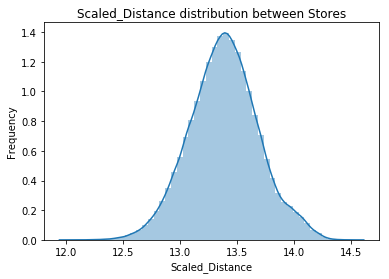

In [953]:
sns.distplot(df_stor_sim['Scaled_Distance'])
plt.ylabel('Frequency')
plt.title('Scaled_Distance distribution between Stores')

In [950]:
mu = df_stor_sim['Scaled_Distance'].mean()
sigma = df_stor_sim['Scaled_Distance'].std()

#Setting the threshold
thres = mu - sigma

+ Thresholding the data based on the percentile cutoff
+ Selecting the value based on that
+ if the distance is more than a threshold, they are not connected---> else connected

In [383]:
df_stor_sim['Indicator'] = df_stor_sim['Scaled_Distance'].apply(lambda x: int(x<thres))

In [384]:
df_stor_sim['Indicator'].value_counts()

0    524018
1     97037
Name: Indicator, dtype: int64

#### Temporal Part is solved. Now is for the Graph Convolution Model

+ First task is to impute the missing information
+ For many stores, it might be possible that information not available--->
    + So main approaches will be to form a new category unknown--
    + Else might be imputed with mode as well

In [385]:
store_data.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [386]:
cat_cols_imp = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear',
           'PromoInterval']
cont_col_imp = ['CompetitionDistance']

In [387]:
for col in cat_cols_imp:
    store_data[col] = store_data[col].replace(np.nan,'Notknown',regex = True)

In [388]:
#Replacing the continuous column
med = store_data['CompetitionDistance'].median()
store_data['CompetitionDistance'] = store_data['CompetitionDistance'].replace(np.nan,med,regex = True)

In [389]:
total_cols = store_data.columns

In [390]:
dict_count = {}
for col in total_cols:
    dict_count[col] = store_data[col].unique().shape[0]

In [391]:
dict_count

{'Store': 1115,
 'StoreType': 4,
 'Assortment': 3,
 'CompetitionDistance': 655,
 'CompetitionOpenSinceMonth': 13,
 'CompetitionOpenSinceYear': 24,
 'Promo2': 2,
 'Promo2SinceWeek': 25,
 'Promo2SinceYear': 8,
 'PromoInterval': 4}

In [392]:
cont_cols = ['CompetitionDistance']
cat_cols =  ['StoreType','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
           'Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']

In [393]:
df_cat = store_data[cat_cols]
df_cont = store_data[cont_cols]

In [394]:
df_cat1 = pd.get_dummies(df_cat)

In [395]:
df_cont1 = (df_cont - df_cont.mean()) / (df_cont.max() - df_cont.min())

In [396]:
df_joined = pd.concat([store_data['Store'],df_cont1,df_cat1],axis=1)

In [938]:
#df_joined.to_pickle('/Users/s0c02nj/Desktop/Store_Cluster/Store_Features')

In [398]:
#df_stor_sim.to_pickle('/Users/s0c02nj/Desktop/Store_Cluster/Store_Similarity_2')
df_stor_sim = df_stor_sim.drop(['Distance','Scaled_Distance'],axis=1)

In [399]:
df_stor_sim[df_stor_sim['Store1'] == 1]['Indicator'].value_counts()

0    792
1    322
Name: Indicator, dtype: int64

In [400]:
#Creating the Graph
order = sorted(list(G.nodes()))

df_ones = df_stor_sim[df_stor_sim['Indicator']==1]
df_ones.index = range(0,len(df_ones))

In [401]:
G = nx.Graph()
G.add_nodes_from(order)

node_ls=[]
for i in range(0,len(df_ones)) :
    node_ls.append((df_ones['Store1'].iloc[i], df_ones['Store2'].iloc[i]))
    
# add edges from txt 
G.add_edges_from(node_ls)

In [402]:
A = to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat_inv = np.linalg.inv(D_hat)

In [403]:
M1 = np.matmul(D_hat_inv,A_hat)

In [404]:
X = df_joined.drop(['Store'],axis=1)
X = X.values
M2 = np.matmul(M1,X)

In [405]:
df_train = pd.DataFrame(M2)

In [412]:
df_train1 = df_train.copy()
df_train1['Store'] = df_joined['Store']

In [414]:
df_stor_sim1 = pd.merge(left = df_stor_sim, right= df_train1, how='left', 
                      left_on=['Store1'], right_on=['Store'])

In [415]:
df_stor_sim2 = pd.merge(left = df_stor_sim1, right= df_train1, how='left', 
                      left_on=['Store2'], right_on=['Store'])

In [423]:
y_lab = df_stor_sim2['Indicator']
df_stor_sim2 = df_stor_sim2.drop(['Store_x','Store_y','Store1','Store2','Indicator'],axis =1)

In [502]:
def l1_reg(weight_matrix):
    return 0.01 * K.sum(K.abs(weight_matrix))

In [576]:
def model_deep():
    
    #Defining the input-----> Continuous Variable
    inputs1 = Input(shape=(df_stor_sim2.shape[1],))
    
    #Dense Layer-----> This will be the Weight Matrix W (n*k)
    layer_dense = Dense(10, activation='tanh')(inputs1)
    layer_dense = BatchNormalization()(layer_dense)
    
    #Output_Pred_Layer
    prob = Dense(1,activation='sigmoid')(layer_dense)
    
    #Final model
    model = Model(inputs= inputs1 ,outputs=prob)
    
    return model

In [577]:
model = model_deep()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 166)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                1670      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10)                40        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 11        
Total params: 1,721
Trainable params: 1,701
Non-trainable params: 20
_________________________________________________________________


In [578]:
model.compile(loss = "binary_crossentropy", 
              optimizer = Adam(lr=0.01), 
              metrics = ['accuracy'])

In [579]:
history = model.fit(df_stor_sim2, y_lab,
                         batch_size = 128, 
                         epochs = 5, 
                         validation_split=0.1,
                    
                         verbose = 1)


Train on 558949 samples, validate on 62106 samples
Epoch 1/5
558949/558949 [==============================] - 15s 27us/step - loss: 0.2037 - acc: 0.9112 - val_loss: 0.2010 - val_acc: 0.9179
Epoch 2/5
558949/558949 [==============================] - 14s 25us/step - loss: 0.1789 - acc: 0.9226 - val_loss: 0.1910 - val_acc: 0.9199
Epoch 3/5
558949/558949 [==============================] - 14s 24us/step - loss: 0.1720 - acc: 0.9257 - val_loss: 0.1789 - val_acc: 0.9229
Epoch 4/5
558949/558949 [==============================] - 14s 24us/step - loss: 0.1685 - acc: 0.9272 - val_loss: 0.1804 - val_acc: 0.9217
Epoch 5/5
558949/558949 [==============================] - 14s 24us/step - loss: 0.1664 - acc: 0.9283 - val_loss: 0.1720 - val_acc: 0.9278


In [572]:
#Defining the Intermediate Layer Model- Continuous
intermediate_model_embed  = Model(inputs=model.input,outputs= model.get_layer('Embed_Layer').output)

In [573]:
#Getting the Continuous Representation
store_embedding = intermediate_model_embed.predict(df_stor_sim2)

In [575]:
#store_embedding[5]
store_embedding[1]

array([-0.21025342,  0.84362066,  0.86950874,  0.17726097,  0.9587733 ],
      dtype=float32)

#### Spectral Rule in GCN

In [711]:
A1 = to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())
A1_hat = A1 + I
D1_hat = np.array(np.sum(A1_hat, axis=0))[0]
D1_hat = np.matrix(np.diag(D1_hat))


In [712]:
#Finding D**-0.5
D2 = np.power(D1_hat,-1/2, where=(D1_hat!=0))
P1 = np.matmul(D2,A_hat)
P2 = np.matmul(P1,D2)

In [713]:
X = df_joined.drop(['Store'],axis=1)
X = X.values
P3 = np.matmul(P2,X)

In [714]:
df_train = pd.DataFrame(P3)

In [715]:
df_train1 = df_train.copy()
df_train1['Store'] = df_joined['Store']

In [935]:
df_train1.head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,Store
0,-0.003125,0.496015,0.638978,0.007198,0.116147,0.233426,0.680358,0.007198,0.308193,0.017647,...,0.072890,0.098256,0.098934,0.005771,0.499734,0.080411,0.314510,0.101095,0.499734,1
1,0.008560,0.574213,0.696107,0.000000,0.135510,0.341643,0.782841,0.000000,0.390420,0.012592,...,0.050873,0.101135,0.081057,0.007753,0.599047,0.144793,0.339219,0.090201,0.599047,2
2,0.011164,0.443083,0.511384,0.000000,0.079637,0.227952,0.548757,0.000000,0.270216,0.000000,...,0.006407,0.046521,0.024383,0.000000,0.375890,0.073124,0.245857,0.124102,0.375890,3
3,-0.013067,0.101232,0.173475,0.000000,0.155892,0.030601,0.134667,0.000000,0.225301,0.000000,...,0.075314,0.014162,0.000000,0.000000,0.258735,0.000000,0.026499,0.074733,0.258735,4
4,0.007912,0.502442,0.632178,0.000000,0.089591,0.271135,0.716481,0.000000,0.276423,0.015182,...,0.052666,0.070565,0.088736,0.009348,0.490462,0.104598,0.317889,0.079955,0.490462,5


In [762]:
df_stor_sim2.shape

(621055, 166)

In [716]:
df_stor_sim1 = pd.merge(left = df_stor_sim, right= df_train1, how='left', 
                      left_on=['Store1'], right_on=['Store'])

In [717]:
df_stor_sim2 = pd.merge(left = df_stor_sim1, right= df_train1, how='left', 
                      left_on=['Store2'], right_on=['Store'])

In [718]:
y_lab = df_stor_sim2['Indicator']
y_cat = to_categorical(y_lab)
df_stor_sim2 = df_stor_sim2.drop(['Store_x','Store_y','Store1','Store2','Indicator'],axis =1)

In [748]:
def model_deep():
    
    #Defining the input-----> Continuous Variable
    inputs1 = Input(shape=(df_stor_sim2.shape[1],))
    
    #Dense Layer-----> This will be the Weight Matrix W (n*k)
    layer_dense = Dense(20, activation='tanh',name = 'Embed_Layer1')(inputs1)
    
    #layer_dense = Dense(5, activation='tanh',name = 'Embed_Layer')(layer_dense)
    layer_dense = BatchNormalization(name = 'Embed_Layer2')(layer_dense)
    
    #Output_Pred_Layer
    prob = Dense(1,activation='sigmoid')(layer_dense)
    
    #Final model
    model = Model(inputs= inputs1 ,outputs=prob)
    
    return model

In [749]:
model = model_deep()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 166)               0         
_________________________________________________________________
Embed_Layer1 (Dense)         (None, 20)                3340      
_________________________________________________________________
Embed_Layer2 (BatchNormaliza (None, 20)                80        
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 21        
Total params: 3,441
Trainable params: 3,401
Non-trainable params: 40
_________________________________________________________________


In [750]:
model.compile(loss = "binary_crossentropy", 
               optimizer = Adam(lr=0.01), 
               metrics = ['accuracy'])

In [751]:
history = model.fit(df_stor_sim2, y_lab,
                         batch_size = 256, 
                         epochs = 20, 
                         validation_split=0.1,
                         verbose = 1)


Train on 558949 samples, validate on 62106 samples
Epoch 1/20
558949/558949 [==============================] - 13s 24us/step - loss: 0.1845 - acc: 0.9233 - val_loss: 0.1745 - val_acc: 0.9275
Epoch 2/20
558949/558949 [==============================] - 11s 19us/step - loss: 0.1610 - acc: 0.9313 - val_loss: 0.1885 - val_acc: 0.9234
Epoch 3/20
558949/558949 [==============================] - 11s 20us/step - loss: 0.1562 - acc: 0.9332 - val_loss: 0.1663 - val_acc: 0.9271
Epoch 4/20
558949/558949 [==============================] - 11s 20us/step - loss: 0.1525 - acc: 0.9348 - val_loss: 0.1573 - val_acc: 0.9334
Epoch 5/20
558949/558949 [==============================] - 11s 20us/step - loss: 0.1506 - acc: 0.9355 - val_loss: 0.1627 - val_acc: 0.9298
Epoch 6/20
558949/558949 [==============================] - 11s 20us/step - loss: 0.1495 - acc: 0.9359 - val_loss: 0.1643 - val_acc: 0.9312
Epoch 7/20
558949/558949 [==============================] - 11s 20us/step - loss: 0.1481 - acc: 0.9364 - val_

In [752]:
#Defining the Intermediate Layer Model- Continuous
intermediate_model_embed  = Model(inputs=model.input,outputs= model.get_layer('Embed_Layer2').output)

In [753]:
#Getting the Continuous Representation
store_embedding = intermediate_model_embed.predict(df_stor_sim2)

In [754]:
#store_embedding[5]
store_embedding[12]

array([-0.15821362,  0.42275143,  0.4586954 , -0.09154677,  0.1998992 ,
        0.6978481 ,  1.0557879 ,  0.32991314,  0.24846923, -0.35840702,
        0.21753335, -0.39915037,  0.7237203 , -0.48450494, -0.5083952 ,
       -0.97517157, -0.0043003 , -0.62615913, -0.15657067,  0.4204285 ],
      dtype=float32)

In [766]:
#Final Embedding Matrix


In [765]:
#df_stor_sim2.shape

In [770]:
df_train1.to_pickle('/Users/s0c02nj/Desktop/Store_Cluster/Output_Embeddings/Store_Embeddings')

In [773]:
feat = df_train1.drop(['Store'],axis=1)

Visualize TSNE Plots

In [912]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [913]:
feat_2d = tsne.fit_transform(feat)

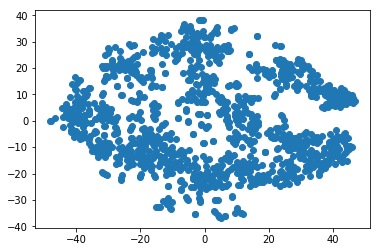

In [914]:
plt.scatter(feat_2d[:,0],feat_2d[:,1])

In [930]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=5,max_iter = 2000)

In [931]:
clust.fit(feat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=2000,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [932]:
labels_clust = clust.labels_

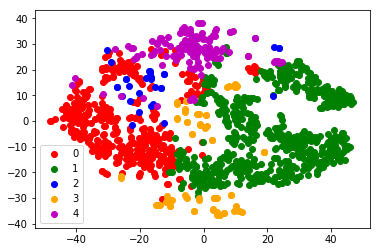

In [933]:
target_ids = range(0,5)

colors = 'r', 'g', 'b', 'orange', 'm'
#'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors,np.unique(labels_clust) ):
    plt.scatter(feat_2d[labels_clust == i, 0], feat_2d[labels_clust == i, 1], c=c, label=label)
plt.legend()
plt.show()


In [934]:
silhouette_score(feat, labels_clust, metric='euclidean')

0.27754041117100264

----->>>>>> Below part is for Conv_Net--------->>>>

In [55]:
import pandas as pd
import numpy as np
import networkx as nx
#import igraph as ig

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # supress warnings due to some future deprications

In [56]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import keras 

from stellargraph import globalvar

Using TensorFlow backend.


In [57]:
import mplleaflet
from itertools import count

In [58]:
sg.core.StellarGraph

stellargraph.core.graph.StellarGraph

In [59]:
df_have_edge= df_stor_sim

In [60]:
df_have_edge.head()

,Store1,Store2,Indicator
0,1,2,0
1,1,3,0
2,1,4,0
3,1,5,0
4,1,6,0


In [61]:
G=nx.from_pandas_edgelist(df_have_edge,source='Store1',target='Store2')

In [62]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1115
Number of edges: 621055
Average degree: 1114.0000


In [63]:
print(nx.number_connected_components(G))

1


In [64]:
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes)

[1115]


In [65]:
filtered_features = df_joined

In [66]:
filtered_features.set_index('Store', inplace=True)

In [67]:
filtered_features.head()

,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceMonth_1.0,...,Promo2SinceYear_2011.0,Promo2SinceYear_2012.0,Promo2SinceYear_2013.0,Promo2SinceYear_2014.0,Promo2SinceYear_2015.0,Promo2SinceYear_Notknown,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_Notknown
Store,,,,,,,,,,,,,,,,,,,,,
1,-0.054412,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,-0.063642,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.115155,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-0.062983,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,0.323225,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [68]:
node_features=filtered_features

In [69]:
node_features.head()

,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceMonth_1.0,...,Promo2SinceYear_2011.0,Promo2SinceYear_2012.0,Promo2SinceYear_2013.0,Promo2SinceYear_2014.0,Promo2SinceYear_2015.0,Promo2SinceYear_Notknown,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_Notknown
Store,,,,,,,,,,,,,,,,,,,,,
1,-0.054412,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,-0.063642,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.115155,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-0.062983,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,0.323225,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [70]:
Gs = sg.core.StellarGraph(G, node_features=node_features)

In [71]:
print(Gs.info())

StellarGraph: Undirected multigraph
 Nodes: 1115, Edges: 621055

 Node types:
  default: [1115]
    Edge types: default-default->default

 Edge types:
    default-default->default: [621055]



In [88]:
# parameter specification
number_of_walks = 5
length = 10
batch_size = 50
epochs = 10
num_samples = [20, 20]
layer_sizes = [100, 100]
learning_rate = 1e-2

In [89]:
unsupervisedSamples = UnsupervisedSampler(Gs, nodes=G.nodes(), length=length, number_of_walks=number_of_walks)

In [90]:
train_gen = GraphSAGELinkGenerator(Gs, batch_size, num_samples).flow(unsupervisedSamples)

Running GraphSAGELinkGenerator with an estimated 2230 batches generated on the fly per epoch.


In [91]:
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [92]:
graphsage.build()

([<tf.Tensor 'input_25:0' shape=(?, 1, 83) dtype=float32>,
  <tf.Tensor 'input_28:0' shape=(?, 1, 83) dtype=float32>,
  <tf.Tensor 'input_26:0' shape=(?, 20, 83) dtype=float32>,
  <tf.Tensor 'input_29:0' shape=(?, 20, 83) dtype=float32>,
  <tf.Tensor 'input_27:0' shape=(?, 400, 83) dtype=float32>,
  <tf.Tensor 'input_30:0' shape=(?, 400, 83) dtype=float32>],
 [<tf.Tensor 'lambda_5/l2_normalize:0' shape=(?, 1, 100) dtype=float32>,
  <tf.Tensor 'lambda_5_1/l2_normalize:0' shape=(?, 1, 100) dtype=float32>])

In [93]:
x_inp, x_out = graphsage.build()

prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [94]:
#x_inp, x_out = graphsage.default_model()
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

In [493]:
# history = model.fit_generator(
#         train_gen,
#         epochs=epochs,
#         verbose=1,
#         use_multiprocessing=False,
#         workers=1,
#         shuffle=True,
#     )

In [ ]:
prediction.get_shape()

### Extracting Node embeddings

In [ ]:
node_ids = list(Gs.nodes())
node_gen = GraphSAGENodeGenerator(Gs, batch_size, num_samples).flow(node_ids)

In [ ]:
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)